In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import dill as pickle
from functools import partial

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<ipython-input-1-8e3882b48121>:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Dataset

## Mobility

In [2]:
mobility_data = pd.read_csv(
    "./Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"],
    dayfirst=True
)
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & 
    (~mobility_data["sub_region_1"].isnull()) &
    (mobility_data["sub_region_2"].isnull())
]
mobility_data_us_temp = mobility_data_us.iloc[:,7:] # keep only relevant columns
mobility_data_us_temp["state"] = mobility_data_us["sub_region_1"]
mobility_data_us_temp.iloc[:,1:-1] = mobility_data_us_temp.iloc[:,1:-1].apply(lambda x: x/100 + 1)
mobility_data_us =  mobility_data_us_temp.reset_index(drop=True)
mobility_data_us = pd.DataFrame({
    "state": mobility_data_us["state"],
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

processed_dfs = []

for state in mobility_data_us["state"].unique():
    d = mobility_data_us[mobility_data_us["state"] == state].copy()
    
    d["HOME"] = d["HOME"].rolling(7).median()
    d["WORK"] = d["WORK"].rolling(7).median()
    d["RECREATIONAL"] = d["RECREATIONAL"].rolling(7).median()
    d["OTHER"] = d["OTHER"].rolling(7).median()

    processed_dfs.append(d)
    
mobility_data_us = pd.concat(processed_dfs)

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cases

In [3]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "./Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"],
    dayfirst=False
)
ms_us_covid = ms_covid[
    (ms_covid["Country_Region"]=="United States") & 
    (~ms_covid["AdminRegion1"].isnull()) &
    (ms_covid["AdminRegion2"].isnull())
]
ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
ms_us_covid.reset_index(drop=True, inplace=True)
population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls",
)
STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))

processed_dfs = []

for state in ms_us_covid["state"].unique():
    d = ms_us_covid[ms_us_covid["state"] == state]
    d = d.fillna(method='ffill').fillna(0)
    d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

    d["S"] = int(STATE_POPULATION[state]) - d["I"]

    d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
    d["I"] = np.log(d["I"].rolling(7).median()+1)
    d["S"] = np.log(d["S"].rolling(7).median()+1)

    d.dropna(inplace=True)
    processed_dfs.append(d)
    
ms_us_covid = pd.concat(processed_dfs)
ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

## Merge

In [4]:
final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"]
)
final_data.dropna(inplace=True)
final_data.set_index("state", inplace=True)

In [5]:
final_data.to_pickle("tmp/final_data.pkl")

# Model

In [6]:
times = None
for s in final_data.index.unique():
    s_times = set(final_data.loc[s, 'Updated'].unique())
    if times is None:
        times = s_times
    else:
        times = times.intersection(s_times)

In [7]:
train_times, test_times = sorted(times)[:-14], sorted(times)[-14:]

train_data = final_data[final_data['Updated'].isin(train_times)]
test_data = final_data[final_data['Updated'].isin(test_times)]

ORDER = 5

N  = final_data.index.nunique()
T_train = len(train_times) - ORDER + 1
T_test = len(test_times)

In [8]:
y_scaler = None
x_scaler = None

def prepare_data(data, training=True):
    global y_scaler, x_scaler
    
    data = data.copy()
    data.reset_index(inplace=True, drop=True)
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]
    
    if training:
        y_scaler = preprocessing.StandardScaler().fit(y)
        x_scaler = preprocessing.StandardScaler().fit(X)
    elif y_scaler is None or x_scaler is None:
        raise RuntimeError("Must be trained first")
        
    y_scaled = y_scaler.transform(y)
    X_scaled = x_scaler.transform(X)
    
    return X_scaled, y_scaled

def train_for_state(name, data):
    X_train, y_train = prepare_data(data, training=True)
    model_params = {
        'kernel': (
            gpflow.kernels.SquaredExponential(lengthscales=np.ones(X_train.shape[1])) +
            gpflow.kernels.Linear() +
            gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X_train.shape[1]))
        )
    }

    model = gpflow.models.VGP(
        data = (X_train, y_train),
        likelihood=gpflow.likelihoods.Gaussian(),
        **model_params
    )

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)
    
    variational_optimizer = gpflow.optimizers.NaturalGradient(gamma=1.0)
    model_variables_optimizer = tf.optimizers.Adam(0.01)
    
    objective_closure = model.training_loss_closure()
    
    elbo = []
    for _ in range(gpflow.ci_utils.ci_niter(1000)):
        model_variables_optimizer.minimize(
            objective_closure,
            model.trainable_variables
        )
        variational_optimizer.minimize(
            objective_closure,
            [(model.q_mu, model.q_sqrt)]
        )
        elbo.append(model.elbo())

    mean_train, var_train = model.predict_y(X_train)
    y_train_pred = y_scaler.inverse_transform(mean_train.numpy())
    y_train_true = y_scaler.inverse_transform(y_train)

    res = y_train_true - y_train_pred
    
    return model, res

## $K(X, X)$

### Marginal Fitting

In [9]:
results_states = {
    state: train_for_state(state, train_data.loc[state])
    for state in train_data.index.unique()
}

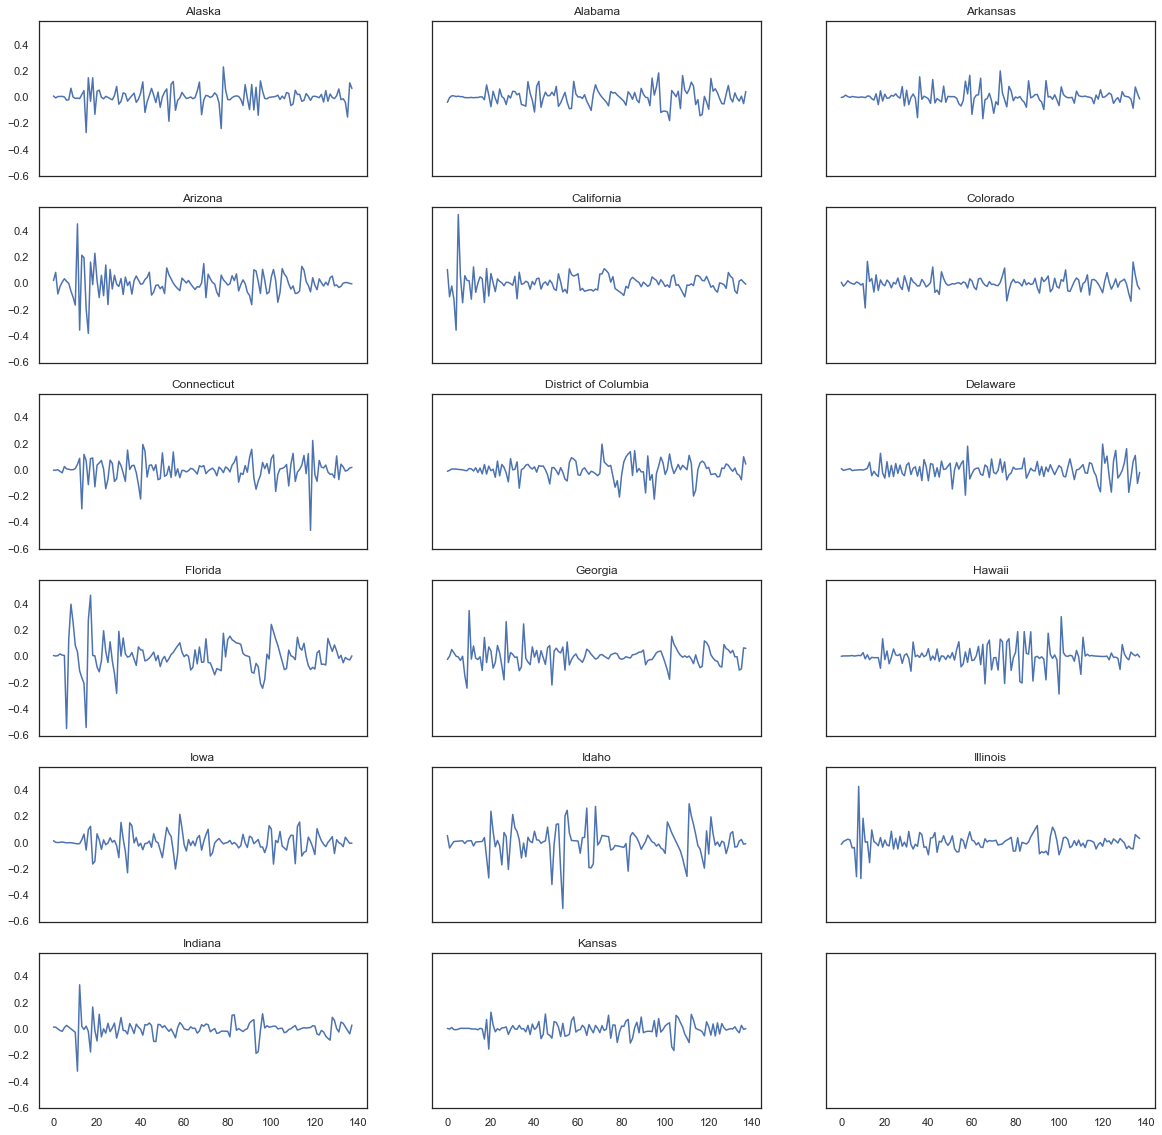

In [10]:
fig, axs = plt.subplots(N // 3 + 1, 3, sharex=True, sharey=True, figsize=(20, 20))
for i, (s, (_, r)) in enumerate(results_states.items()):
    ax = axs[i//3, i % 3]
    ax.plot(r)
    ax.set_title(s)

### Marginal Kernels

In [11]:
ks_mm = np.zeros((T_train*N, T_train*N))
for s_i, (state, (m_i, r_i)) in enumerate(results_states.items()):
    X, y = prepare_data(train_data.loc[state].iloc[ORDER-1:], training=False)
    k = m_i.kernel(X).numpy()
    ks_mm[s_i*T_train:(s_i+1)*T_train, s_i*T_train:(s_i+1)*T_train] = k

### White noise

In [12]:
np.random.seed(123)

dates = pd.date_range(train_data[["Updated"]].min().values[0], train_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-26,-1.085631
1,2020-02-27,0.997345
2,2020-02-28,0.282978
3,2020-02-29,-1.506295
4,2020-03-01,-0.578600


<AxesSubplot:>

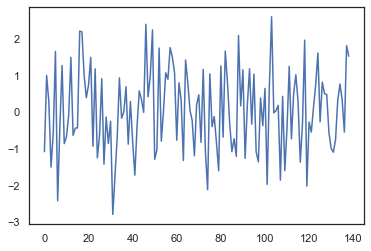

In [13]:
u0["Residual"].plot()

### Linear filters

In [14]:
linear_filters_states = {}

for state in results_states.keys():
    u0_ = u0[u0['Updated'].isin(train_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)

    def _yule_walker(u=None, coeff_=None, sigma_=None):
        return np.convolve(coeff_, u, mode="same")

    rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
    rho_ = np.array(rho_)[::-1]
    linear_filters_states[state] = rho_, partial(
        _yule_walker, u=u0_["Residual"].values, coeff_=tuple(rho_), sigma_=sigma_
    )

### Rhos

In [15]:
rhos_mm = np.zeros((T_train*N, T_train*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        convol = np.convolve(hX, hY[::-1], mode="same")
        for t in range(T_train):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T_train - t + len(convol)//2)]
            jstart = j*T_train+max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_mm[i*T_train+t, jstart:jend] = data

# validation
for x in range(N):
    for y in range(N):
        for t in range(T_train):
            for s in range(T_train):
                assert rhos_mm[x*T_train+t, y*T_train+s] == rhos_mm[y*T_train+s, x*T_train+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{XY}}_{{t,s}} = \rho^{{YX}}_{{s,t}}"
                assert rhos_mm[y*T_train+t, x*T_train+s] == rhos_mm[x*T_train+s, y*T_train+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{YX}}_{{t,s}} = \rho^{{XY}}_{{s,t}}"

In [16]:
rhos_mm.shape

(2278, 2278)

### Kmm

In [17]:
Kmm = ks_mm + rhos_mm

In [18]:
Kmm_1 = tf.linalg.inv(Kmm)

---

## $K(X_*, X_*)$

### Marginal Kernels

In [19]:
ks_nn = np.zeros((T_test*N, T_test*N))
for s_i, (m_i, r_i) in enumerate(results_states.values()):
    X, y = prepare_data(test_data.loc[state], training=False)
    k = m_i.kernel(X).numpy()
    ks_nn[s_i*T_test:(s_i+1)*T_test, s_i*T_test:(s_i+1)*T_test] = k

In [20]:
ks_nn.shape

(238, 238)

### Rhos

In [21]:
rhos_nn = np.zeros((T_test*N, T_test*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        hX_test = hX
        hY_test = hY
        convol = np.convolve(hX_test, hY_test[::-1], mode="same")
        for t in range(T_test):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T_test - t + len(convol)//2)]
            jstart = j*T_test+max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_nn[i*T_test+t, jstart:jend] = data

# validation
for x in range(N):
    for y in range(N):
        for t in range(T_test):
            for s in range(T_test):
                assert rhos_nn[x*T_test+t, y*T_test+s] == rhos_nn[y*T_test+s, x*T_test+t], \
                f"x={x}, y={y}, t={t}, s={s} => rho^XY_t,s = rho^YX_s,t"
                assert rhos_nn[y*T_test+t, x*T_test+s] == rhos_nn[x*T_test+s, y*T_test+t], \
                f"x={x}, y={y}, t={t}, s={s} => rho^YX_t,s = rho^XY_s,t"

In [22]:
rhos_nn.shape

(238, 238)

### Knn

In [23]:
Knn = ks_nn + rhos_nn

---

## $K(X, X_*)$

### Marginal Kernels

In [24]:
ks_mn = np.zeros((T_train*N, T_test*N))
for s_i, (m_i, r_i) in enumerate(results_states.values()):
    X_train, y_train = prepare_data(train_data.loc[state].iloc[ORDER-1:], training=False)
    X_test, y_test = prepare_data(test_data.loc[state], training=False)
    k = m_i.kernel(X_train, X_test).numpy()
    ks_mn[s_i*T_train:(s_i+1)*T_train, s_i*T_test:(s_i+1)*T_test] = k

In [25]:
ks_mn.shape

(2278, 238)

### Rhos

In [26]:
rhos_mn = np.zeros((T_train*N, T_test*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        hX_test = hX
        hY_test = hY
        convol = np.convolve(hX_test, hY_test[::-1], mode="same")
        for t in range(T_test):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T_test - t + len(convol)//2)]
            jstart = j*T_test + max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_mn[i*T_train+t, jstart:jend] = data

### Kmn

In [27]:
Kmn = ks_mn + rhos_mn

---

## $K(X_*, X)$

### Marginal Kernels

In [28]:
ks_nm = np.zeros((T_test*N, T_train*N))
for s_i, (m_i, r_i) in enumerate(results_states.values()):
    X_train, y_train = prepare_data(train_data.loc[state].iloc[ORDER-1:], training=False)
    X_test, y_test = prepare_data(test_data.loc[state], training=False)
    k = m_i.kernel(X_test, X_train).numpy()
    ks_nm[s_i*T_test:(s_i+1)*T_test, s_i*T_train:(s_i+1)*T_train] = k

In [29]:
ks_nm.shape

(238, 2278)

### Rhos

In [30]:
rhos_nm = np.zeros((T_test*N, T_train*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        hX_test = hX
        hY_test = hY
        convol = np.convolve(hX_test, hY_test[::-1], mode="same")
        for t in range(T_test):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T_train - t + len(convol)//2)]
            jstart = j*T_train + max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_nm[i*T_test+t, jstart:jend] = data

### Knm

In [31]:
Knm = ks_nm + rhos_nm

---

## Prediction

In [136]:
y_train = np.empty((T_train*N,1))
y_test = np.empty((T_test*N,1))
for s_i, state in enumerate(results_states.keys()):
    _, y_tr = prepare_data(train_data.loc[state].iloc[ORDER-1:], training=False)
    _, y_te = prepare_data(test_data.loc[state], training=False)
    y_train[s_i*T_train:(s_i+1)*T_train,:] = y_tr
    y_test[s_i*T_test:(s_i+1)*T_test,:] = y_te

In [137]:
y_train.shape, y_test.shape

((2278, 1), (238, 1))

In [138]:
# train
A_train = tf.linalg.matmul(Kmm, Kmm_1)

mean_train = tf.linalg.matmul(A_train, y_train)
var_train = Kmm - tf.linalg.matmul(A_train, Kmm)

# test
A_test = tf.linalg.matmul(Knm, Kmm_1)

mean_test = tf.linalg.matmul(A_test, y_train)
var_test = Knn - tf.linalg.matmul(A_test, Kmn)

---

In [139]:
y_trains = dict(zip(results_states.keys(), tf.split(y_train, N)))
y_tests = dict(zip(results_states.keys(), tf.split(y_test, N)))

y_hat_trains = dict(zip(results_states.keys(), tf.split(mean_train, N)))
y_hat_tests = dict(zip(results_states.keys(), tf.split(mean_test, N)))

for y_dict in (y_trains, y_tests, y_hat_trains, y_hat_tests):
    for k, v in y_dict.items():
        y_dict[k] = v[:,0]

In [140]:
def plot_for_state(state, ax=None):
    if not ax:
        _fig, ax = plt.subplots(1, figsize=(15, 4))
        
    t_test = test_data.loc[state]["index"].values
    t = train_data.loc[state].iloc[ORDER-1:]["index"].values

    y = y_trains[state]
    y_test = y_hat_tests[state]
    y_hat = np.concatenate([y_hat_trains[state], y_test])

    ax.plot(np.concatenate([t, t_test]), y_hat, "-", c="C0")
    ax.plot(t, y, "o", c="C2", alpha=0.7, label="train")
    ax.plot(t_test, y_test, "o", c="C3", alpha=0.7, label="test")
    ax.legend()
    ax.set_title(state)

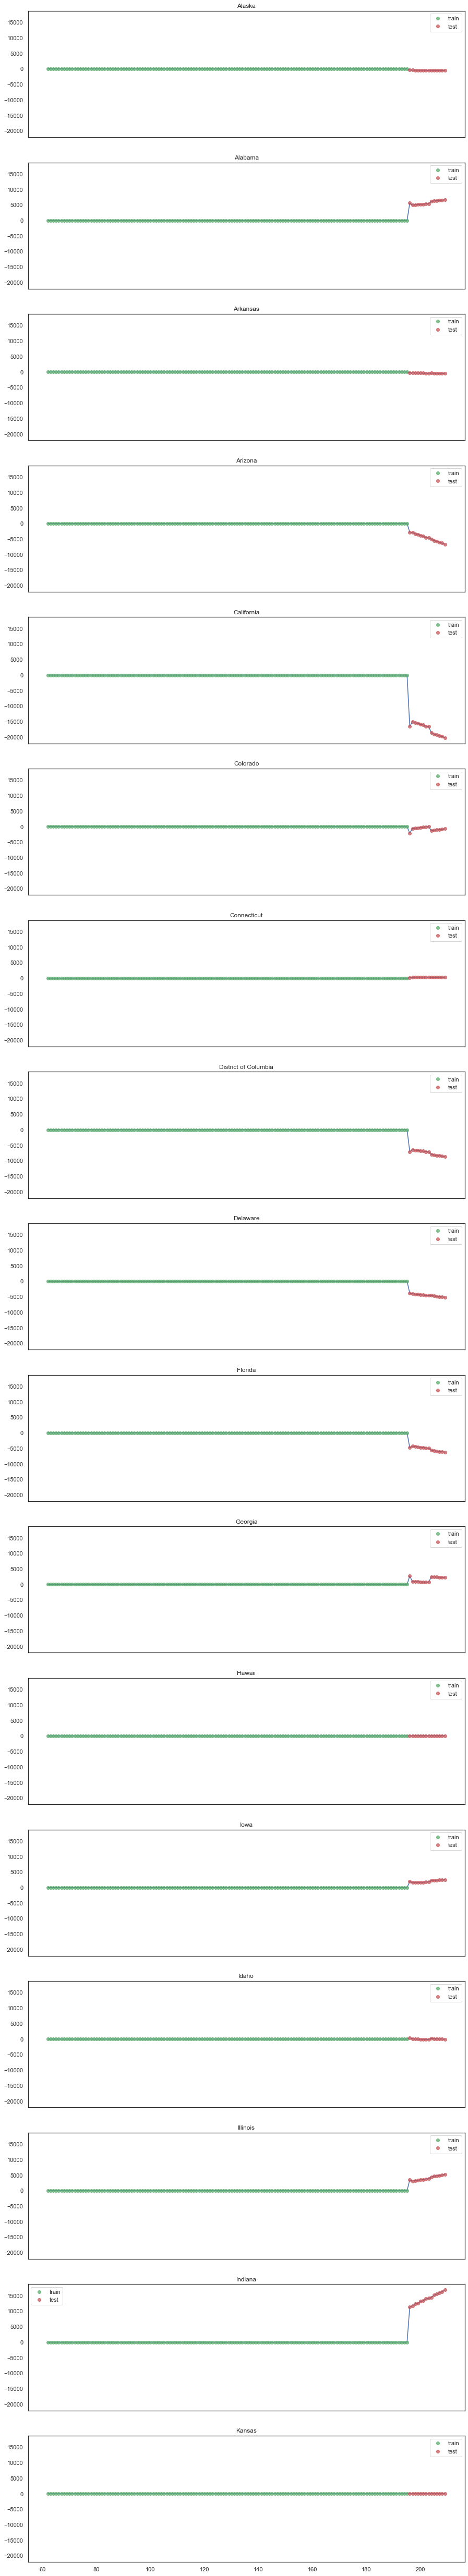

In [141]:
fig, axs = plt.subplots(N, 1, sharex=True, sharey=True, figsize=(15, 90))
for i, s in enumerate(results_states.keys()):
    ax = axs[i]
    plot_for_state(s, ax=ax)